In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [18, 8]

pd.set_option('max_colwidth', -1)

In [2]:
items_df = pd.read_csv('/kaggle/input/lazada-indonesian-reviews/20191002-items.csv')
reviews_df = pd.read_csv('/kaggle/input/lazada-indonesian-reviews/20191002-reviews.csv')

print('Items shape:', items_df.shape)
print('Reviews shape:', reviews_df.shape)

Items shape: (10942, 9)
Reviews shape: (203787, 15)


## Data Cleaning

### 1. Category doesn't match with items name, so we cannot use this feature for prediction

In [3]:
items_df[['category', 'name']].head()

,category,name
0,beli-harddisk-eksternal,"TOSHIBA Smart HD LED TV 32"" - 32L5650VJ Free Bracket TV - Hitam - Khusus Jabodetabek"
1,beli-harddisk-eksternal,"TOSHIBA Full HD Smart LED TV 40"" - 40L5650VJ - Hitam - Khusus Jabodetabek"
2,beli-harddisk-eksternal,Samsung 40 Inch Full HD Flat LED Digital TV 40J5000
3,beli-harddisk-eksternal,"Sharp HD LED TV 24"" - LC-24LE175I - Hitam"
4,beli-harddisk-eksternal,"Lenovo Ideapad 130-15AST LAPTOP MULTIMEDIA I AMD A4-9125 I 8GB DDR4 I 1TB HDD I AMD Radeon R3 I 15,6 HD LED I DVDRW I DOS"


### 2. Delete null values & unimportant features

In [4]:
null_col = reviews_df.columns[reviews_df.isna().any()]
review_null = reviews_df[null_col].isna().sum().rename('Total Null').to_frame()
review_null['percentage'] = round(review_null['Total Null'] / reviews_df.shape[0] * 100, 1)
review_null['percentage'] = review_null['percentage'].astype(str)

review_null.style.background_gradient('Blues')

,Total Null,percentage
originalRating,203779,100.0
reviewTitle,180383,88.5
reviewContent,96758,47.5
boughtDate,7107,3.5


In [5]:
items_df.drop(['retrievedDate', 'category'], axis=1, inplace=True)
reviews_df.drop(['retrievedDate', 'category', 'originalRating', 'reviewTitle', 'helpful'], axis=1, inplace=True)

print('Features has been dropped')

Features has been dropped


### 3. Duplicated rows can make bias in prediction, so we must drop..

In [6]:
print("Items duplicated rows:", items_df.duplicated().sum())
print("Reviews duplicated rows", reviews_df.duplicated().sum())

items_df.drop_duplicates(inplace=True)
reviews_df.drop_duplicates(inplace=True)

print('\nDuplicated rows has been dropped')

Items duplicated rows: 6520
Reviews duplicated rows 122673

Duplicated rows has been dropped


### 4. Text Cleaning for recommendation model

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[-/|()+&\[\]]', ' ', text)
    text = re.sub(r'khusus|daerah|jabodetabek|medan|murah|indonesia|gratis|ongkir|garansi|tahun|harga|ecer|jadetabek|ready', '', text)
    text = re.sub(r'100%|ori', ' ', text)
    tokenizer = text.split()
    return ' '.join([word for word in tokenizer])

items_df['name'] = items_df['name'].apply(clean_text)

In [8]:
items_df.head()

,itemId,name,brandName,url,price,averageRating,totalReviews
0,100002528,"toshiba smart hd led tv 32"" 32l5650vj free bracket tv hitam",Toshiba,https://www.lazada.co.id/products/toshiba-smart-hd-led-tv-32-32l5650vj-free-bracket-tv-hitam-khusus-jabodetabek-i100002528-s100003593.html?search=1,2499000,4,8
1,100003785,"toshiba full hd smart led tv 40"" 40l5650vj hitam",Toshiba,https://www.lazada.co.id/products/toshiba-full-hd-smart-led-tv-40-40l5650vj-hitam-khusus-jabodetabek-i100003785-s100006061.html?search=1,3788000,3,3
2,100004132,samsung 40 inch full hd flat led digital tv 40j5000,LG,https://www.lazada.co.id/products/samsung-40-inch-full-hd-flat-led-digital-tv-40j5000-i100004132-s100006644.html?search=1,3850000,3,2
3,100004505,"sharp hd led tv 24"" lc 24le175i hitam",Sharp,https://www.lazada.co.id/products/sharp-hd-led-tv-24-lc-24le175i-hitam-i100004505-s100007387.html?search=1,1275000,3,11
4,100005037,"lenovo ideapad 130 15ast laptop multimedia i amd a4 9125 i 8gb ddr4 i 1tb hdd i amd radeon r3 i 15,6 hd led i dvdrw i dos",Lenovo,https://www.lazada.co.id/products/lenovo-ideapad-130-15ast-laptop-multimedia-i-amd-a4-9125-i-8gb-ddr4-i-1tb-hdd-i-amd-radeon-r3-i-156-hd-led-i-dvdrw-i-dos-i100005037-s100008405.html?search=1,3984100,5,1


In [9]:
reviews_df.head()

,itemId,name,rating,reviewContent,likeCount,upVotes,downVotes,relevanceScore,boughtDate,clientType
0,100002528,Kamal U.,5,bagus mantap dah sesui pesanan,0,0,0,26.51,09 Apr 2019,androidApp
1,100002528,yofanca m.,4,"Bagus, sesuai foto",0,0,0,22.49,24 Sep 2017,androidApp
2,100002528,Lazada Customer,5,okkkkk mantaaaaaaapppp ... goood,0,0,0,21.50,04 Apr 2018,androidApp
3,100002528,Lazada Customer,4,bagus sesuai,0,0,0,20.51,22 Sep 2017,androidApp
4,100002528,Yosep M.,5,NaN,0,0,0,16.01,17 Agu 2018,androidApp


In [10]:
print('After cleaned:\n')
print('Items shape:', items_df.shape)
print('Reviews shape:', reviews_df.shape)

After cleaned:

Items shape: (4422, 7)
Reviews shape: (81114, 10)


## EDA

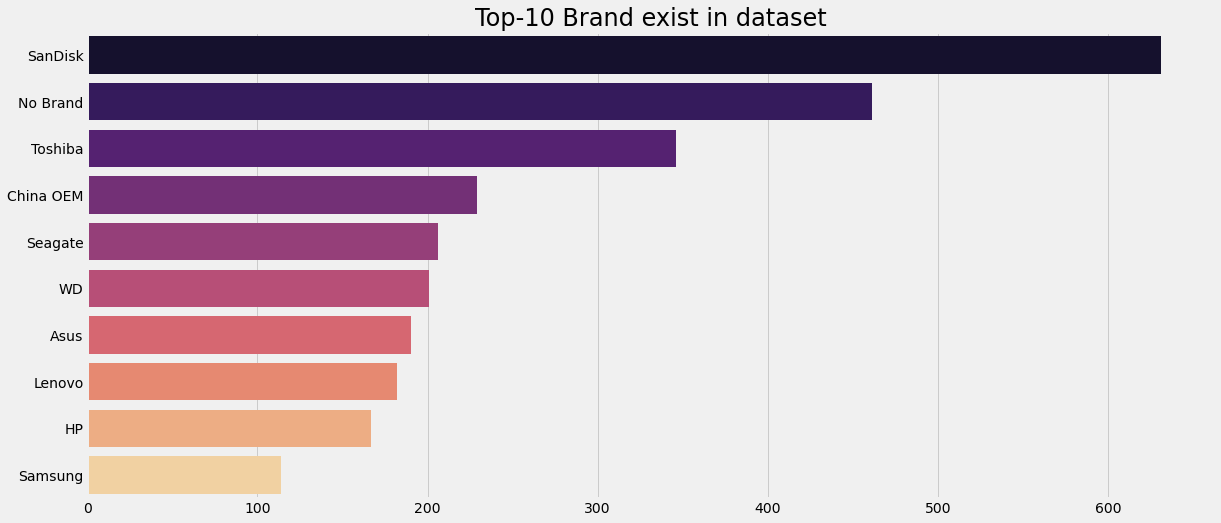

In [11]:
brand_count = items_df['brandName'].value_counts()[:10]

sns.barplot(x=brand_count.values,
            y=brand_count.index,
            palette='magma').set_title('Top-10 Brand exist in dataset', fontsize=24);

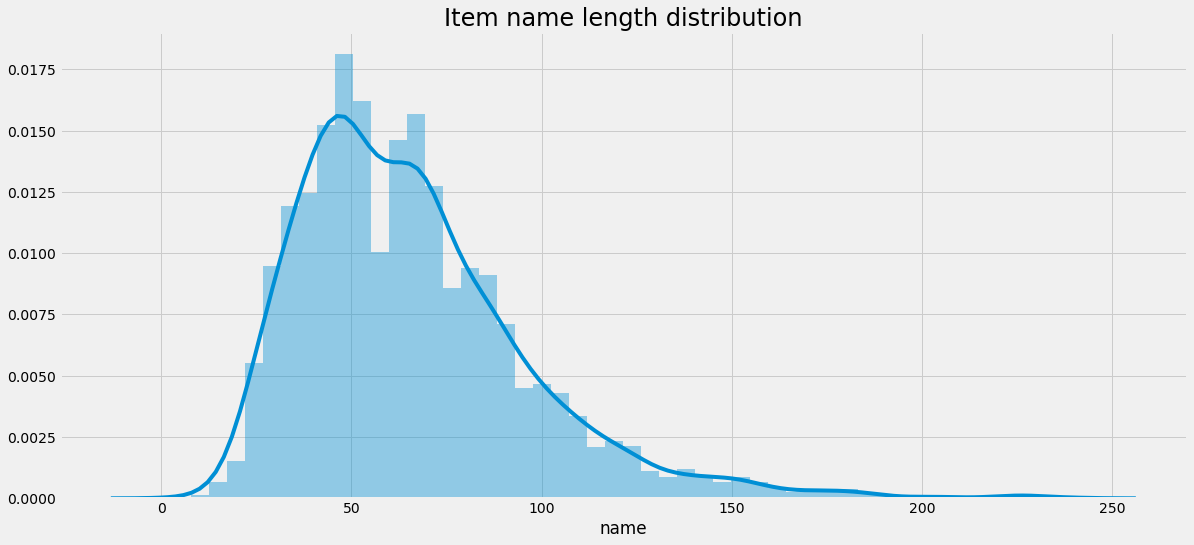

In [12]:
sns.distplot(items_df['name'].str.len()).set_title('Item name length distribution', fontsize=24);

## Topic Modeling

Topic Models are a type of statistical language models used for uncovering hidden structure in a collection of texts. This can be useful for recommendation, search engines etc.

Topic modeling use unsupervised-learning method. If we compared to clustering, the number of topics are like the number of clusters as output parameter.

* We already drop category features above because it doesn't match with items name
* Since category is very important for recommendation, **we can categorize by ourself using topic modeling**
* There are two popular approaches: LDA & NMF

# Latent Dirichlet Allocation

![LDA](https://socs.binus.ac.id/files/2018/11/dw-3.jpg)

1. Probabilistic approaches
1. View each document as a mixture of a small number of topics
1. Words and documents get probability scores for each topic

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=3, max_df=0.75)
doc_term_matrix = vectorizer.fit_transform(items_df['name'])

doc_term_matrix

<4422x1374 sparse matrix of type '<class 'numpy.int64'>'
	with 43833 stored elements in Compressed Sparse Row format>

* Each of 4422 documents is represented as 1374 dimensional vector
* Which means that our vocabulary has 1374 words.

In [39]:
from sklearn.decomposition import LatentDirichletAllocation

# use LDA to create topics along with the probability distribution for each word in our vocabulary for each topic
LDA = LatentDirichletAllocation(n_components=4, random_state=2020)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=4, random_state=2020)

1. The first topic contains the probabilities of 1975 words for topic 1
1. To sort the indexes according to probability values, we can use the argsort() function
1. Once sorted, the 10 words with the highest probabilities will now belong to the last 10 indexes of the array

In [40]:
first_topic = LDA.components_[0]
top_topic_words = first_topic.argsort()[-10:]

print(top_topic_words)
print()

for i in top_topic_words:
    print(vectorizer.get_feature_names()[i])

[1286 1079 1150  892  698  682  109  723  827 1261]

usb
resmi
smart
model
hitam
hd
32
inch
led
tv


Let's print the 10 words with highest probabilities for all the 4 topics:

In [41]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['usb', 'resmi', 'smart', 'model', 'hitam', 'hd', '32', 'inch', 'led', 'tv']


Top 10 words for topic #1:
['16gb', '32gb', 'otg', 'disk', 'drive', 'sandisk', 'gb', 'flash', 'flashdisk', 'usb']


Top 10 words for topic #2:
['lenovo', 'asus', '10', 'core', 'ram', '1tb', '14', 'laptop', 'intel', '4gb']


Top 10 words for topic #3:
['wd', 'hard', '1tb', 'pouch', 'hardisk', 'harddisk', 'eksternal', 'external', 'hdd', 'usb']




## From this result, i make a hypothesis (we'll check after this):

* Topic 0: TV
* Topic 1: flaskdisk
* Topic 2: Laptop
* Topic 3: Hard-disk

Then we will add a column to the original data frame that will store the topic for the text. To do so, we can use LDA.transform() method and pass it our document-term matrix. This method will assign the probability of all the topics to each document.

In [42]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(4422, 4)

In [43]:
items_df['category'] = topic_values.argmax(axis=1)

## Check

In [45]:
# TV
items_df[items_df['category'] == 0]['name'].sample(10)

86      sharp 24" 24le1751 led aquos tv lc tt hitam                                                                                   
1977    lg 24tk425a led tv monitor 24 inch                                                                                            
2115    tv 32inch polytron type pld32t1550                                                                                            
2809    penjualan terbaik 10.1 inch 2 gb ram 32 gb rom komputer tablet jaringan 3g wifi sim rangkap dua kartu untuk android 6.0 sistem
700     sharp lc 32le180 aquos led tv 32" hitam                                                                                       
1866    anycast miracast 1080p m2 plus wifi hdmi dongle tampilan receiver dlna tv ginal                                               
1817    samsung full hd tv 40 inch model 40n5000                                                                                      
3144    samsung hd tv 24 inch model: 24h4150 series 4 d

In [46]:
# flaskdisk
items_df[items_df['category'] == 1]['name'].sample(10)

995     toshiba flashdisk hayabusa 32 gb putih beli 1 1                                         
4380    autoleader 32 gb usb 2.0 biru led lampu model bohlam mem flashdisk flashdisk u disk intl
2000    sandisk cruzer blade flashdisk 8gb hitam                                                
2455    flashdisk sandisk 32gb cruzer blade cz50                                                
3447    flashdisk usb flash disk usb flash drive toshiba 4gb free kabel otg                     
2511    flashdisk flasdisk flashdis flasdis flash drive hp 16gb kyo                             
1234    flashdisk toshiba 32gb bonus flashdisk 16gb dan otg                                     
20      flashdisk usb toshiba hayabusa flashdrive 32gb white                                    
3892    sandisk usb flash disk cruzer blade 8gb                                                 
4324    sandisk ultra fit usb 3.0 flash drive 16gb black                                        
Name: name, dtype: object

In [47]:
# Laptop
items_df[items_df['category'] == 2]['name'].sample(10)

3449    laptop gaming msi gl63 8sc 013id black ci7 8750h 8gb 512gb gtx1650 15.6inch win10 free msi backpack                          
2371    dell inspiron 3467 ci3 7020u, 4gb, 1 tb, intel hd, windows hitam free mouse dell wm 126                                      
3594    acer predator nitro 5 an515 52 intel core i5 8300h,16gb ram,1tb hdd 128gb ssd,15.6" fhd,gtx 1050 4gb,win 10 carbon body resmi
1574    acer e3 112 c08p silver                                                                                                      
511     toshiba c55 c2052 intel core i3 5005m ram 4gb 500gb 15,6" gold                                                               
1166    exclusive lazada hp 15 db0005au amd dual core e2 9000e 4 gb ddr4 500 gb 15.6" w10 black laptop tas ber                       
3661    asus vivobook ultra a412da ek302t notebook ryzen 3 3200u radeon vega 3 4gb 1tb win10 14" slate grey esel                     
3609    laptop hp pavilion x360 11 ab128tu black celeron n4000

In [48]:
# Hard-disk
items_df[items_df['category'] == 3]['name'].sample(10)

588     wd my passport new design 4tb 2.5inch usb3.0 putih free pouch pen                                                                                                        
2206    transcend storejet 25h3 4tb biru hardisk external antishock                                                                                                              
2764    seagate backup plus slim 1tb biru free pouch                                                                                                                             
1593    western digital elements 2.5" 750gb hitam                                                                                                                                
3372    tas dompet travel carger softcase shockproof tas earphone case kotak penyimpanan mini organizer serbaguna k183                                                           
1691    promo ginal harddisk external adata hd 710m military grade strength free case harddisk sarung tangan o

In [49]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", LDA.score(doc_term_matrix))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", LDA.perplexity(doc_term_matrix))

Log Likelihood:  -245375.9802729427
Perplexity:  212.82711739804452


In [50]:
import pyLDAvis
from pyLDAvis import sklearn

# pyLDAvis.enable_notebook()
# vis = sklearn.prepare(LDA, doc_term_matrix, vectorizer)

# vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.252876 -0.073104  1       1        34.982531
3      0.106259 -0.087006  2       1        27.708091
2     -0.294949 -0.164706  3       1        23.828680
0     -0.064185  0.324815  4       1        13.480698, topic_info=           Term         Freq        Total Category  logprob  loglift
600   flashdisk  1254.000000  1254.000000  Default  30.0000  30.0000
1261  tv         612.000000   612.000000   Default  29.0000  29.0000
827   led        564.000000   564.000000   Default  28.0000  28.0000
597   flash      946.000000   946.000000   Default  27.0000  27.0000
1102  sandisk    644.000000   644.000000   Default  26.0000  26.0000
...       ...           ...          ...       ...      ...      ...
1199  tablet     37.346860    58.917757    Topic4  -5.1073   1.5480 
611   free       67.331269    366.243477   Topic4  -4.5180   0.3102 
1286  usb        88.603690    1910.976025  Topic4  -4.2434  -1.0673 
1282  untuk      45.375026    155.306438   Topic4  -4.9126   0.7735 
296   android    46.715116    180.190644   Topic4  -4.8835   0.6540 

[210 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4     1      0.004603  10     
4     3      0.952832  10     
4     4      0.041427  10     
25    3      0.998851  14     
35    3      0.938470  15     
...  ..           ...  ..     
1331  2      0.997349  wd     
1335  3      0.044076  wifi   
1335  4      0.947628  wifi   
1337  3      0.994359  win10  
1340  3      0.996370  windows

[235 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

# Non-Negative Matrix Factorization

* Non-negative matrix factorization is also a unsupervised-learning technique which performs clustering as well as dimensionality reduction
* Apply methods from linear algebra to decompose a single matrix (e.g. document-term-matrix) into a set of smaller matrices
* It can be used in combination with TF-IDF scheme to perform topic modeling.

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(min_df=2, max_df=0.8)
nmf_term_matrix = tfidf_vect.fit_transform(items_df['name'])

nmf_term_matrix

<4422x1975 sparse matrix of type '<class 'numpy.float64'>'
	with 45035 stored elements in Compressed Sparse Row format>

In [66]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=4, init='nndsvd', random_state=2020)
nmf.fit(nmf_term_matrix)

NMF(init='nndsvd', n_components=4, random_state=2020)

In [67]:
for i, topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['otg', 'hp', 'disk', '64gb', 'gb', 'drive', 'usb', 'toshiba', 'flash', 'flashdisk']


Top 10 words for topic #1:
['my', 'pouch', '1tb', 'seagate', 'hardisk', 'eksternal', 'wd', 'harddisk', 'hdd', 'external']


Top 10 words for topic #2:
['polytron', 'model', 'resmi', 'smart', 'hitam', 'hd', '32', 'inch', 'led', 'tv']


Top 10 words for topic #3:
['hitam', '32gb', 'usb', 'ultra', 'flashdisk', '16gb', 'cz50', 'blade', 'cruzer', 'sandisk']




## Result:

1. In this experiment, LDA performed better than NMF, we can see above NMF did not make a good categorize for laptop
1. But i didn't tuning the model, if you interested you can use gridsearchCV to find a good hyperparameter for LDA / NMF
1. We also can tuning CountVectorizer / TfidfVectorizer to use bi-gram or tri-gram

### Reference

[Python for NLP: Topic Modeling](https://stackabuse.com/python-for-nlp-topic-modeling/)

[LDA in Python](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)